# Data validation
The main idea of this notebook is to validate the dataset is ready for training. To do that first I will check that the data can be loaded correclty and the transformations done in preprocessing are correct. I will check if the data is consistent and if there are any missing values. Afterwards, I will analyze many batch creation and data augmentation techniques that I will use during the model training in order to achieve the best results. The general schema will be the following:

* 1. Data loading and verification
* 2. Batch creation
* 3. Data augmentation
* 4. Conclusion

First I load the necessary libraries:

In [14]:
import os
import sys
import pandas as pd
import numpy as np
import yaml
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from collections import defaultdict
import altair as alt

# Set seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import ROOT_DIR, PROCESSED_AFFECTNET_DIR, NUMBER_OF_EMOT, AFFECTNET_CAT_EMOT
    from src.visualization.visualize import  visualize_batch, compute_cat_label_batch_entropy
    from src.data.dataset import AffectNetDatasetValidation
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

# 1. Data loading and verification
In this section I will analyze the data and check if it is consistent and if there are any missing values. I will also check if the transformations done in the preprocessing are correct. I will start by loading the flags used during the preprocessing step.

In [15]:
# Path of the parameters file
params_path = os.path.join(ROOT_DIR,"params.yaml")

# Read data preparation parameters
with open(params_path, "r", encoding='utf-8') as params_file:
    try:
        params = yaml.safe_load(params_file)
        params = params["preprocessing"]
    except yaml.YAMLError as exc:
        print(exc)

# Convert the params dictionary to a DataFrame
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['Value'])
# Print the DataFrame
print(params_df)

                                Value
random_seed                        33
orig_datasets             [affectnet]
train_split                       0.8
categorical_format         hard_label
continuous_format           cartesian
face_detection_algorithm         None


Now I will load the data and check the main features of each data split: 

In [16]:
for data_split in ["train.pkl", "val.pkl", "test.pkl"]:
    print(f"Processing {data_split}-------------------")
    data = pd.read_pickle(os.path.join(PROCESSED_AFFECTNET_DIR, data_split))
    print(f"Shape of the data: {data.shape}")
    print(data.info())

Processing train.pkl-------------------


Shape of the data: (230120, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230120 entries, 0 to 230119
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   key        230120 non-null  int64 
 1   img_path   230120 non-null  object
 2   cat_emot   230120 non-null  object
 3   cont_emot  230120 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.0+ MB
None
Processing val.pkl-------------------
Shape of the data: (57531, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57531 entries, 0 to 57530
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   key        57531 non-null  int64 
 1   img_path   57531 non-null  object
 2   cat_emot   57531 non-null  object
 3   cont_emot  57531 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB
None
Processing test.pkl-------------------
Shape of the data: (3999, 4)
<class 'pandas.core.frame.DataF

All values are consistent with the preprocessing and there are no missing values. I will check now that the label values are inside the ranges of the transformation specified by the preprocessing flags. I take small subset of the data for this purpose to speed up the process:

In [17]:
for data_split in os.listdir(PROCESSED_AFFECTNET_DIR):
    if data_split.endswith('.pkl'):
        print(f"-------------------\tAnalyzing {data_split}\t-------------------")
        data = pd.read_pickle(os.path.join(PROCESSED_AFFECTNET_DIR, data_split))
        random_idx_list = np.random.randint(0, len(data), 2500)
        for idx in random_idx_list:
            sample = data.iloc[idx]               
            # Check if the variables type
            if not isinstance(sample['img_path'], str):
                print(f"Index: {idx}, img_path is not a string.")
            if not isinstance(sample['cat_emot'], torch.Tensor):
                print(f"Index: {idx}, cat_emot is not a PyTorch tensor.")
            if not isinstance(sample['cont_emot'], torch.Tensor):
                print(f"Index: {idx}, cont_emot is not a PyTorch tensor.")

            # Check if the variables are in correct format
            if sample['cat_emot'].numpy().sum() != 1 or len(sample['cat_emot'].numpy()) != NUMBER_OF_EMOT: # Check if the encoding sums to 1, i.e. one-hot encoding (it can be soft or hard)
                print (f"Index: {idx}, cat_emot is has incorrect encoding.")
            if sample['cont_emot'].numpy().shape != (2,):
                    print(f"Index: {idx}, cont_emot has more than 2 values.")
            if params['continuous_format'] == 'cartesian':
                if sample['cont_emot'].numpy()[0] < -1 or sample['cont_emot'].numpy()[0] > 1:
                    print(f"Index: {idx}, valence is not in the range [-1, 1].")
                if sample['cont_emot'].numpy()[1] < -1 or sample['cont_emot'].numpy()[1] > 1:
                    print(f"Index: {idx}, arousal is not in the range [-1, 1].")
            elif params['continuous_format'] == 'polar':
                if sample['cont_emot'].numpy()[0] < 0 or sample['cont_emot'].numpy()[0] > 1:
                    print(f"Index: {idx}, radius is not in the range [0, 1].")
                if sample['cont_emot'].numpy()[1] < 0 or sample['cont_emot'].numpy()[1] > np.pi:
                    print(f"Index: {idx}, phase is not in the range [0, pi].")

-------------------	Analyzing test.pkl	-------------------
-------------------	Analyzing train.pkl	-------------------
-------------------	Analyzing val.pkl	-------------------


As no output is shown, I can conclude that the data is consistent. We can now proceed with the batch creation and data augmentation. 

# 2. Batch creation
The main idea of this section is to check if the dataloader works correctly and if I can solve the issue of data imbalance by using a weighted batch sampler. I will focus on categorical labels for this purpose. So this section can be divided in the following two steps:
* 2.1. Dataloader creation and verification 
* 2.2. Weighted batch sampler

## 2.1 Dataloader creation and verification

I will start by creating a batch of data and checking if the dataloader works correctly. I will use a subset of size `batch_size * bacthes` for this purpose.

In [18]:
batch_size = 32
batches = 100
selected_rows = range(batch_size*batches)

Now I load the data and create the data dataloaders:

In [19]:
# Create the datasets
dataset_train = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "train.pkl"))
dataset_val = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "val.pkl"))
dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"))
# Take a subset of the datasets
dataset_train = torch.utils.data.Subset(dataset_train, selected_rows)
dataset_val = torch.utils.data.Subset(dataset_val, selected_rows)
dataset_test = torch.utils.data.Subset(dataset_test, selected_rows)
# Create the dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Now I will plot the first batch of data to check if the dataloader works correctly (for training split):

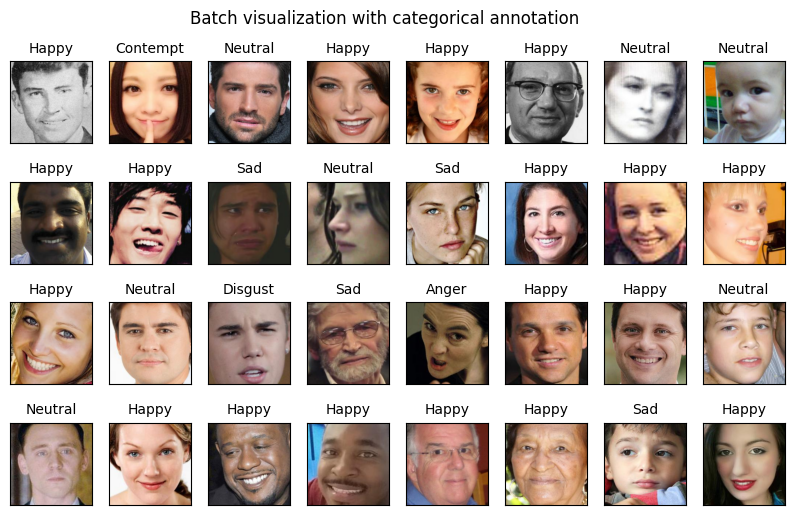

In [20]:
dataiter = iter(dataloader_train)
_, img, cat_label, cont_label = next(dataiter)
visualize_batch(img, cat_label)

Dataloaders work correctly and images are ready to be trained. Now I will focus on the data imbalance issue. I will check the distribution of the labels in the training set and create a weighted batch sampler to solve the issue. I will use the same data loader.

## 2.2 Weighted batch sampler
As we have seen in data exploration, there is a heavy bias towards positive emotions, concretly to happy and neutral emotions. In this section I will focus on creating a weighted batch sampler to solve this issue. I will focus on the categorical labels for this purpose. I will use the same data loader.

To get a sense on how the emotions are distributed in each batch I will be using entropy. Entropy is the measure of suprise or uncertainty of the variables possible outcomes. So it is a good measure to see how uncertain the categorical labels in a batch will be (as we expect it to be as high as possible). This is the mathematical definition:

$$H(X):=-\sum_{x\in \mathcal{X}} p(x)· log(p(x))$$

**Note:** The choice of base for the logarithm, varies for different applications. I will use base $e$, so it is in "natural units" nat.

The lower bound of entropy is a deterministic event, where in a batch we have only one emotion (in this case the entropy is 0).
$$H(D)=- 1 · log(1)=-log(1) = 0$$

The objective is that all batches labels are as uncertain as possible. So we seek the uniform distribution of categorical labels in each batch, so that will be the upper bound of this measure. In case of a uniform distribution of 8 possible outcomes or emotions the entropy value is the following: 
$$H(U)=-\sum_{i=1}^{8}  1/8 · log(p(i))=-log(1/8) \approx 2.079$$

Now I will plot the entropy of the labels across the batches for all data splits:

In [21]:
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train")
bar_plot_val = compute_cat_label_batch_entropy(dataloader_val, NUMBER_OF_EMOT, title = "Validation")
bar_plot_test = compute_cat_label_batch_entropy(dataloader_test, NUMBER_OF_EMOT, title = "Test")
alt.hconcat(bar_plot_train, bar_plot_val, bar_plot_test).properties(
    title = alt.Title("Entropy of batches regarding the categorical labels in the datasets", anchor = "middle", fontSize = 20))

alt.HConcatChart(...)

It can be observed that `train` and `validation` splits have a similar entropy and it is far from the upper bound, as these splits have unbalanced labels. Some emotions are more common so there is "less suprise" when they appear in the batch. This means that if we forward these batches to the model, it will have a bias to predict the most common emotions. 

This is not the case for the `test` split, as it has a higher entropy closer to the upper bound that represents the uniform distribution. This is due to the fact that the test split by nature was created to be as close as possible to the uniform distribution of the labels. There is few variability in the entropy across the batches as the sampling from this uniform dataset is random (so this uniformity may change). 

The idea is to create a weighted dataloader, so that the model sees the same amount of each emotion in each batch. This is important because the model will learn to predict the most common emotion if the distribution of emotions is not uniform. First I load the data weights generated from data preprocessing:

In [64]:
train_weights = torch.load(os.path.join(PROCESSED_AFFECTNET_DIR, "data_weights_train.pt"))
print(f"Train weights: {train_weights}")

Train weights: tensor([9.2809e-06, 3.3124e-04, 1.6717e-05,  ..., 8.8944e-05, 9.2809e-06,
        5.0153e-05])
Train weights shape: torch.Size([230120])


Now I create the weighted random sampler. The weight for each class is the reciprocal of the total times it appear on the dataset (already computed in preprocessing). This will ensure that classes with a higher representation will have a smaller weight. I will take the same subset of the data for this purpose:

In [65]:
reduced_train_weights = torch.empty(len(dataset_train))
it = 0 # Index of the reduced_train_weights
for idx in dataset_train.indices:
    reduced_train_weights[it] = train_weights[idx]
    it += 1

Now I will create the dataloader using these weights using the small subset. 

In [62]:
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler=sampler)

Looking at the torch weighted random sampler function, I have set ``replacement`` as true in order to oversample the smaller categories and by nature undersample the majority classes. For now, I have set the number of samples per epoch as the length of the dataset, but this could be changed. 

Now I will plot the entropy of the labels across the batches for the training data split with/out the weighted random sampler:

In [25]:
selected_rows = range(min(batch_size*batches, len(dataset_train)))
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train without weighting")
bar_plot_train_weighted = compute_cat_label_batch_entropy(dataloader_train_weighted, NUMBER_OF_EMOT, title = "Train weighted")
alt.hconcat(bar_plot_train, bar_plot_train_weighted).properties(
    title = alt.Title("Entropy of batches with/out weighted sampling", anchor = "middle", fontSize = 20))

alt.HConcatChart(...)

Looking at the chart, we can see an overall improvement in the entropy of the labels across the batches. The entropy is closer to the upper bound, so the model will see a more uniform distribution of emotions in each batch. This will help the model to learn to predict all emotions equally, so the weighted random sampler is working correctly and it is effective solving the data imbalance issue.

But as I have mentioned, the function oversamples small categories. Now I will analyze how often a certain image with a certain emotion is seen, in order to get an oversampling or undersampling notion. I take a small subset of the data for this purpose and compute the evolution after 20 epochs. 

In [26]:
total_images = batch_size * batches
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler, drop_last=True)

In [27]:
total_epochs = 20
image_counts = defaultdict(lambda:0) # Initialize the image_counts dictionary
image_emotion = defaultdict(lambda:0) # Initialize the image_emotion dictionary
distinct_images_seen = []
emotions_reseen = []
for epoch in range (total_epochs):
    for i, (ids, _, cat_emot, _) in enumerate(dataloader_train_weighted):
        emot = cat_emot.argmax(dim=1).numpy()
        it = 0
        for id in ids.numpy():
            # Increment the count for id in image_counts
            image_counts[id] += 1
            if id not in image_emotion:
                image_emotion[id] = emot[it]  
            it += 1
    # Update the distinct_images_seen for the epoch
    distinct_images_seen.append({'Epoch': epoch+1, 'Seen dataset': len(image_counts)/total_images}) 
    print(f"Epoch {epoch+1} - Seen dataset: {len(image_counts)/total_images}")

    # Update the emotions_reseen for the epoch
    emotions_counts = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
    for id in dataset_train.indices:
        # Append the emotion to the list of the corresponding emotion, if not found append 0
        emotions_counts[image_emotion[id]].append(image_counts.get(id,0)) 
        
    for emotion in range(NUMBER_OF_EMOT):
        average = sum(emotions_counts[emotion])/len(emotions_counts[emotion])
        emotions_reseen.append({'Epoch': epoch + 1, 'Emotion': emotion, 'Average seen': average})

    # Check if all the images have been seen
    if distinct_images_seen[epoch]['Seen dataset'] == 1.0:
        break

Epoch 1 - Seen dataset: 0.43
Epoch 2 - Seen dataset: 0.6109375
Epoch 3 - Seen dataset: 0.719375
Epoch 4 - Seen dataset: 0.79125
Epoch 5 - Seen dataset: 0.8453125
Epoch 6 - Seen dataset: 0.8859375
Epoch 7 - Seen dataset: 0.9165625
Epoch 8 - Seen dataset: 0.9365625
Epoch 9 - Seen dataset: 0.95375
Epoch 10 - Seen dataset: 0.9640625
Epoch 11 - Seen dataset: 0.9734375
Epoch 12 - Seen dataset: 0.980625
Epoch 13 - Seen dataset: 0.984375
Epoch 14 - Seen dataset: 0.9884375
Epoch 15 - Seen dataset: 0.9915625
Epoch 16 - Seen dataset: 0.994375
Epoch 17 - Seen dataset: 0.995
Epoch 18 - Seen dataset: 0.995
Epoch 19 - Seen dataset: 0.99625
Epoch 20 - Seen dataset: 0.996875


Now I show the results. I will focus first on the evolution of how many times an image is seen per emotion:

In [28]:
emotions_reseen_df = pd.DataFrame(emotions_reseen)
cat_emot_dict = {id:AFFECTNET_CAT_EMOT[id] for id in range(NUMBER_OF_EMOT)}
emotions_reseen_df['Emotion'] = emotions_reseen_df['Emotion'].map(cat_emot_dict)

In [29]:
line_plot = alt.Chart(emotions_reseen_df).mark_line().encode(
    x=alt.X('Epoch:O', title='Epoch', axis=alt.Axis(labelAngle=0)),
    y='Average seen',
    color=alt.Color('Emotion:N', legend=alt.Legend(title='Emotion', labelColor='black', titleColor='black')),
).properties(
    title='Average same photo seen w.r.t an emotion over epochs',
    width=400,
    height=300
)

line_plot += alt.Chart(emotions_reseen_df).mark_point(size=50, filled=True).encode(
    x=alt.X('Epoch:O', title='Epoch'),
    y='Average seen:Q',
    color=alt.Color('Emotion:N', legend=alt.Legend(title='Emotion', labelColor='black', titleColor='black')),
    tooltip=[
        alt.Tooltip('Emotion', title='Emotion'),    
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Average seen', title='Average seen', format='.2f'),
    ]
)

line_plot.interactive()


alt.LayerChart(...)

As expected, the growth in all emotions is linear, and the growth is invsersly proportional to how many times the emotion is seen in the dataset. This is the expected behavior of the weighted random sampler. Emotions as `Contempt` and `Disgust` are much more oversampled with almost 200 visualizations per photo after 20 epochs. In the other side, `Happy` and `Neutral` are seen less often, with only 6-8 times per photo after the epochs.

Now I will compute oversampling and undersmapling factor for each emotion:

In [30]:
last_epoch = emotions_reseen_df.loc[emotions_reseen_df['Epoch'] == 20, ['Emotion', 'Average seen']].reset_index(drop=True)
last_epoch['Average seen'] = last_epoch['Average seen'] / 20

In [68]:
sampling_factor = alt.Chart(last_epoch).mark_point(size=200, filled=True).encode(
    x=alt.X('Emotion:O', title='Emotion', sort='y', axis = alt.Axis(labelAngle=0)),
    y=alt.Y('Average seen:Q', title='Average seen per epoch (log-scale)', scale=alt.Scale(type='log', base=10, domain=[0.1, 10])),
    tooltip=[
        alt.Tooltip('Emotion', title='Emotion'),    
        alt.Tooltip('Average seen', title='Average seen per epoch', format='.2f'),
    ]
).properties(
    title=alt.Title("Average seen per emotion over the last epoch", anchor="middle", fontSize=20),
    width=400,
    height=300
)
line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(color='black', strokeWidth=2).encode(y='y:Q')
sampling_factor_with_line = alt.layer(sampling_factor, line)

sampling_factor_with_line = sampling_factor_with_line + alt.Chart(pd.DataFrame({'text': ['Sampling Factor 1']})).mark_text(
    align='left',
    baseline='middle',
    dx=5,
    dy=-5,
    fontSize=12,
    fontWeight='bold'
).encode(
    x=alt.value(0),
    y=alt.value(143),
    text='text'
)

sampling_factor_with_line.interactive()

alt.LayerChart(...)

And here it can be observed the notion of oversampling and undersampling. I use the log-scale in the ``Average seen per epoch`` axis in order to get a better sense when comparing the ratios. The value is basically the step of the line in the previous chart. Almost all categories are oversampled. And only `Happy` and `Neutral` are undersampled. This is the expected behavior of the weighted random sampler. As each photo of less common emotions is seen more often, I will need to find good augmentation techniques to avoid overfitting.

Now I will study the effect sampling the dataset, as when we sample with replacement, it is possible to not see all the images after many iterations. I will take a subset of the data and see the epoch evolution. 

In [69]:
distinct_images_seen_df = pd.DataFrame.from_dict(distinct_images_seen)
line_plot = alt.Chart(distinct_images_seen_df).mark_line().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (1, 20))),
    y=alt.Y('Seen dataset:Q', title='Acumulative seen dataset'),
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Acumulative seen dataset', format='.2%')
    ]
).properties(
    height=300,
    width=600,
)

line_plot += alt.Chart(distinct_images_seen_df).mark_point().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (1, 20))),
    y='Seen dataset:Q',
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Percentage of dataset seen', format='.2%')
    ]
)

line_plot += alt.Chart(pd.DataFrame({'value': [0.95]})).mark_rule(color='black', strokeDash=[5, 5]).encode(
    y='value:Q'
)

line_plot += alt.Chart(pd.DataFrame({'text': ['Confidence of 95%']})).mark_text(
    baseline='middle',
    dx = -215,
    dy = 7,
    fontSize=12,
).encode(
    y=alt.value(0.95),
    text='text'
)

line_plot.properties(title=alt.Title("Acumulative seen dataset per epoch", anchor="middle", fontSize=20))

alt.LayerChart(...)

It can be seen how after 20 epochs, on the small dataset not all the images have been seen. This is natural as when we sample a dataset with replacement, we will see some images more than once and some not at all. But 95% of the images have been seen at least once after the 9th epoch.

Now I will make many experiments and store the epoch where the dataset seen surpasses the 95% threshold. And finally plot a histogram showing the time where is accomplishes the 95% threshold. I will take a subset of the data for this purpose.

In [34]:
total_experiments = 15
threshold = 0.95
epoch_results = []

for experiment in range(total_experiments):
    print(f"Experiment {experiment} -")
    total_epochs = 20
    image_set = set()
    for epoch in range (total_epochs):
        for i, (ids, _, _, _) in enumerate(dataloader_train_weighted):
            for id in ids.numpy():
                image_set.add(id)        
        print(f"Epoch {epoch+1} - Seen dataset: {len(image_set)/total_images}")
        if len(image_set) > threshold * total_images:
            epoch_results.append({'Experiment': experiment, 'Epoch': epoch+1})
            break

Experiment 0 -
Epoch 1 - Seen dataset: 0.4403125
Epoch 2 - Seen dataset: 0.621875
Epoch 3 - Seen dataset: 0.7284375
Epoch 4 - Seen dataset: 0.8
Epoch 5 - Seen dataset: 0.850625
Epoch 6 - Seen dataset: 0.8928125
Epoch 7 - Seen dataset: 0.914375
Epoch 8 - Seen dataset: 0.9375
Epoch 9 - Seen dataset: 0.95375
Experiment 1 -
Epoch 1 - Seen dataset: 0.4378125
Epoch 2 - Seen dataset: 0.6115625
Epoch 3 - Seen dataset: 0.7240625
Epoch 4 - Seen dataset: 0.7996875
Epoch 5 - Seen dataset: 0.85375
Epoch 6 - Seen dataset: 0.8909375
Epoch 7 - Seen dataset: 0.921875
Epoch 8 - Seen dataset: 0.939375
Epoch 9 - Seen dataset: 0.951875
Experiment 2 -
Epoch 1 - Seen dataset: 0.425625
Epoch 2 - Seen dataset: 0.62625
Epoch 3 - Seen dataset: 0.74
Epoch 4 - Seen dataset: 0.8146875
Epoch 5 - Seen dataset: 0.8609375
Epoch 6 - Seen dataset: 0.898125
Epoch 7 - Seen dataset: 0.926875
Epoch 8 - Seen dataset: 0.943125
Epoch 9 - Seen dataset: 0.9584375
Experiment 3 -
Epoch 1 - Seen dataset: 0.4384375
Epoch 2 - Seen dat

Now I show a histogram plot of the epochs when the model surpasses 95% seen dataset:

In [75]:
# Define the bin edges
bins = range(0, 20)

# Create a new column for the bin each epoch falls into
df_epoch_results['EpochBin'] = pd.cut(df_epoch_results['Epoch'], bins=bins, right=False, labels=False)

# Create the histogram plot
hist_plot = alt.Chart(df_epoch_results).mark_bar().encode(
    x=alt.X('EpochBin:O', title='Epoch'),
    y=alt.Y('count():Q', title='Frequency'),
    tooltip=[
        alt.Tooltip('count()', title='Frequency'),
        alt.Tooltip('Epoch', title='Epoch')
    ]
).properties(
    title='Histogram of Epoch Results'
)
hist_plot

alt.Chart(...)

# 3. Data augmentation
Now I will look over many techniques used in data augmentation and see how the parameters can be used in order to improve the model. The idea is to apply an on-the-fly data augmentation, so the images are not the same during the training, this way it can be reduced the way the model sees the oversampled images.  The general schema will be the following:
* 3.1. Normalization
* 3.2. Random Affine
* 3.3. Random Horizontal Flip
* 3.4. Color Jitter
* 3.5. Gaussian Blur
* 3.6. Random Erasing
* 3.7. Conclusions of data augmentation 


**Note**: All the transformations are done using the ``torchvision.transforms.v2`` transforms instead of those in ``torchvision.transforms``. As they have a faster implementation and there are more transformations that can be applied.




Now I will create an small batch of data and apply many data augmentation techniques to see how they work:



In [37]:
batch_size = 4
batches = 1
selected_rows = range(batch_size*batches)

I define two small functions. One loads the data and creates the dataloaders using the specified transformations, and then plots the resulting images. The other one computes the mean and standard deviation of the pixel values applying the transformation.

In [38]:
def show_transformation (img_transforms):
    # Create the datasets
    dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"), img_transforms=img_transforms)
    # Take a subset of the datasets
    dataset_test = torch.utils.data.Subset(dataset_test, selected_rows)
    # Create the dataloaders
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False) # No need to shuffle as we are showing the same images
    for epoch in range (2):
        for i, (ids, imgs, _, _) in enumerate(dataloader_test):
            visualize_batch(imgs, col = 4) 

In [39]:
def compute_mean_std (dataloader):
        PIXELS_IMAGE = 224 * 224
        count = len(dataloader.dataset)
        pixel_count = count * PIXELS_IMAGE
        
        # Initialize the sum and sum of squares
        psum = torch.tensor([0.0, 0.0, 0.0])
        psum_sq = torch.tensor([0.0, 0.0, 0.0])
        for inputs in tqdm(dataloader):
                imgs = inputs[1]
                psum += imgs.sum(axis=[0, 2, 3])
                psum_sq += (imgs**2).sum(axis=[0, 2, 3])
        
        # Compute final metrics
        pixel_count = count * PIXELS_IMAGE
        total_mean = psum / pixel_count
        total_var = (psum_sq / pixel_count) - (total_mean**2)
        total_std = torch.sqrt(total_var)
        return {'mean': total_mean, 'std': total_std}

Mean:
$$\mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$
$$\sigma = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 = \sum_{i=1}^{N} (x_i^2) - \frac{1}{N} · \left(\sum_{i=1}^{N}x_i\right)^2$$
$$std = \sqrt \sigma $$

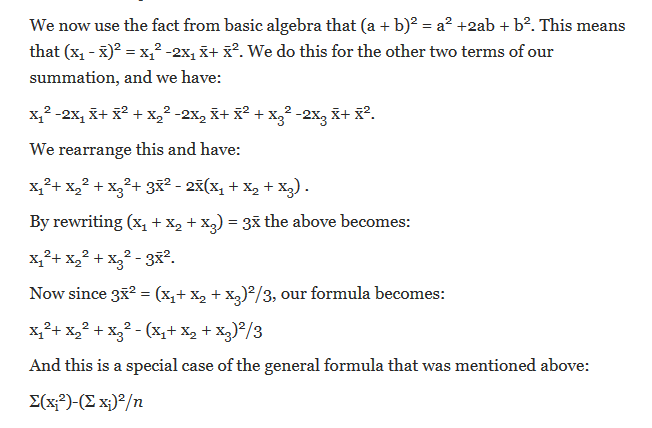

We can observe the images with no transformation:

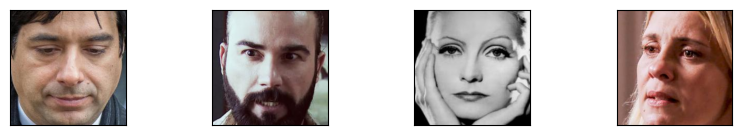

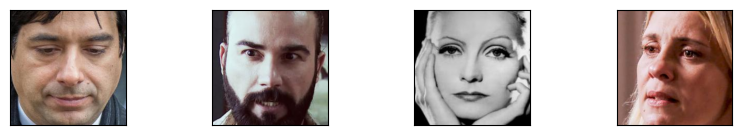

In [40]:
no_norm = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1],
])
show_transformation(no_norm)

It can be seen how all images in these two epochs are exactly the same ones. I will start my analysis focusing on normalization. 

## 3.1. Normalization

It is tipically used in the context of computer vision but is more a standarization step than a data augmentation one, but it is trivial in our project. It is advisable to normalize image pixel values relative to the dataset mean and standard deviation. This helps converge faster, get consistent results when applying a model to new unseen information and can also it is useful for transfer learning. The values tipically used are the ones obtained from ImageNet:
$$mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]$$

Nervertheless, I decided to compute my own metrics for the AffectNet dataset and see if they differ. We can load the values precomputed using the python program `AffectNet_normalization_values.py`

In [41]:
normalization_values = torch.load(
os.path.join (PROCESSED_AFFECTNET_DIR, 'dataset_normalization_values.pt'))
print(normalization_values)
mean = normalization_values['mean'].numpy()
std = normalization_values['std'].numpy()

{'mean': tensor([0.5694, 0.4460, 0.3912]), 'std': tensor([0.2746, 0.2446, 0.2382])}


Now we compare the obtained results using these two values for the validation datasplit. We will choose the one that gives a result a mean value of image around 0 and standard deviation 1: 

In [42]:
normalization_ImageNet = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True),
])
normalization_AffectNet = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.Normalize(mean=mean, std=std, inplace=True),
])

We start with the general normalization used, using the ImageNet values: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


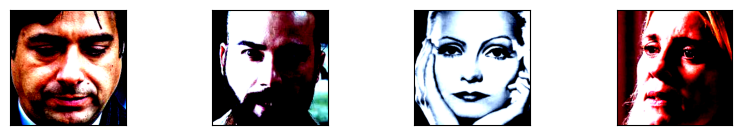

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


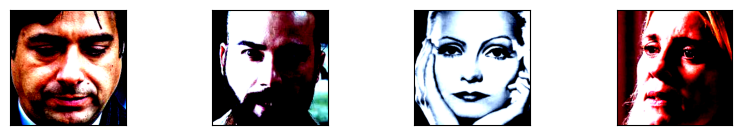

In [43]:
show_transformation(normalization_ImageNet)

We can observe how some images are clipped. This is expected as the normalization must not always lead to having all values around [0,1] interval, as the normalization I'm applying is to the general distribution, to be centered around 0 and have 1 in std. All images tend to be redish, as ImageNet is not thought to be a face dataset (in general faces tend to have warmer colors). Now we can compute the mean and std values for the validation dataset using ImageNet values and see if the distribution has these mean and std values. 

In [44]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"), img_transforms=normalization_ImageNet)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:09<00:00, 13.15it/s]


{'mean': tensor([ 0.3186, -0.0829, -0.0947]),
 'std': tensor([1.2094, 1.1023, 1.0700])}

It can be observed how there is a good performing around blue and green channels but not in the red channel. This is due to the fact that the image dataset pixel value distribution is different from the ImageNet. Now we repeat the same experiment with the values computed from the AffectNet dataset:

**Note**: The values computed with AffectNet are done using the `default` flag, this means that the ``train`` and ``validation`` splits are used to compute the mean and std values. The test split is not used for this purpose as it is used to evaluate the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


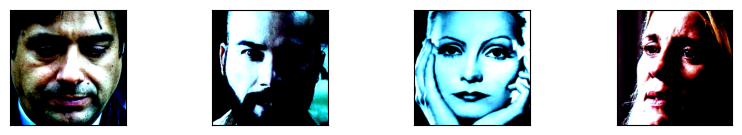

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


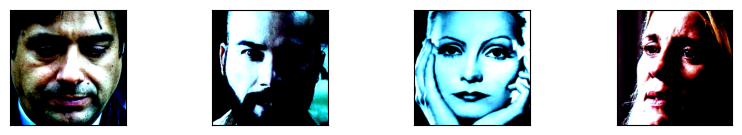

In [45]:
show_transformation(normalization_AffectNet)

It can be observed that now images have a whiter result (with less warmer colors). One thing to note is that black and white images by nature will be set with blueish tones. So at first glance the mean and std values computed from the AffectNet dataset are better. But now we will confirm that using the test set. As the test set is not used to compute the mean and std values, it is a good way to check if the normalization is well done and the distribution of data is similar. 

In [46]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"), img_transforms=normalization_AffectNet)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:09<00:00, 13.83it/s]


{'mean': tensor([-0.0418, -0.0352, -0.0271]),
 'std': tensor([1.0087, 1.0095, 1.0105])}

The results are much better, almost all channels are around 0 in mean and 1 std. So we will use the mean and std values computed from the AffectNet dataset for training and validating the model. As the test set is not used  sdwfnewnownef. This will be the last step of the data augmentation that is more a standarization step that a data augmentation step. 


Now I will proceed with ``Random Affine`` transformation:

## 3.2. Random Affine
Radom Affine transformation is a combination of rotation, translation, scale and shear. It is a good way to augment the data and make the model more robust. I will use the following parameters:

In [47]:
RandomAffine = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.9, 1)),
])

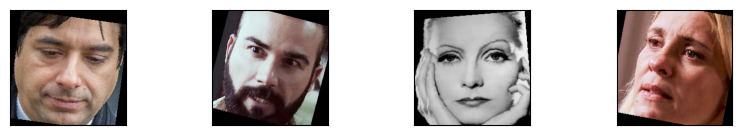

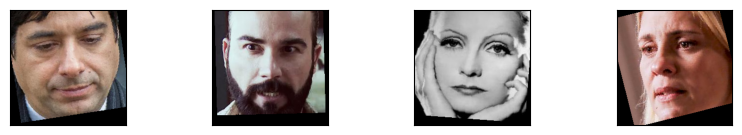

In [48]:
show_transformation(RandomAffine)

## 3.3. Random horizontal flip
This is useful to get invariance around the mirror effect, as some cameras use it and some not. Also it helps the model to be more robust, as in general faces are simetric around the vertical axis. I won't apply a vertical flip, as it is not usual to see inverted faces. I will use the following parameters:


In [49]:
RandomHorizontalFlip = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.RandomHorizontalFlip(p = 0.5),
])

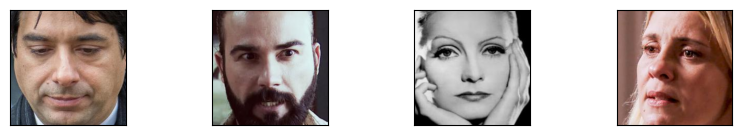

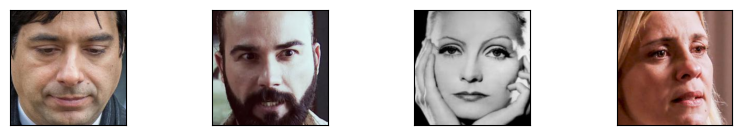

In [50]:
show_transformation(RandomHorizontalFlip)

## 3.4. ColorJitter
This transformation is used to change the brightness, contrast, saturation and hue of the image. It is useful to make the model more robust and to get invariance to these changes in light conditions (common in a car situation) I will use the following parameters:

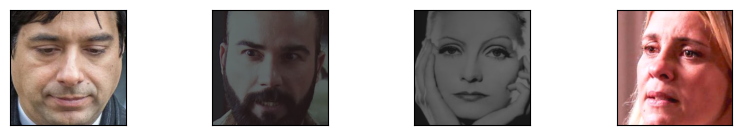

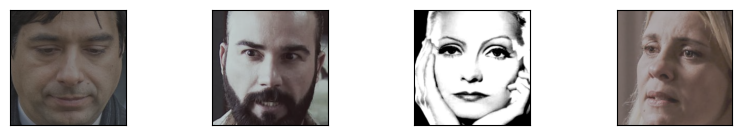

In [51]:
ColorJitter = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.ColorJitter(brightness=[0.5, 1.5],contrast = [0.5, 1.5], saturation = [0.5,1.5], hue=[-0.025, 0.025]),
])
show_transformation(ColorJitter)

Maintain the high variance in condition lights but less color changes.

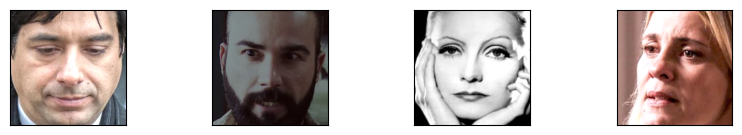

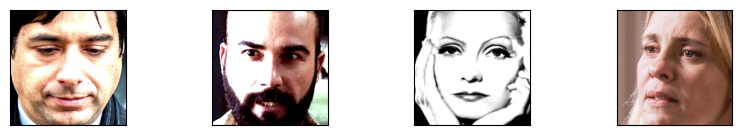

In [52]:
ColorJitter = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.ColorJitter(brightness=[0.5, 1.5],contrast = [0.5, 1.5], saturation = [0.75,1.25], hue=[-0.01, 0.01]),
])
show_transformation(ColorJitter)

A less aggressive version of it:

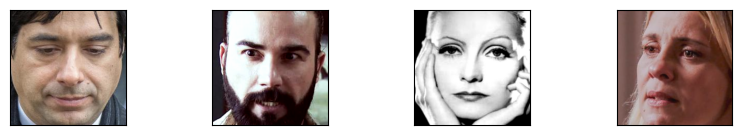

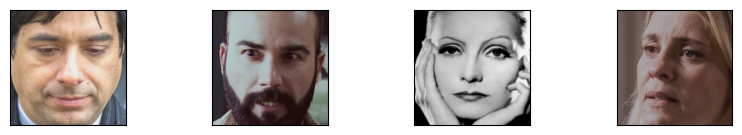

In [53]:
ColorJitter = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.ColorJitter(brightness=[0.75, 1.25],contrast = [0.75, 1.25], saturation = [0.75,1.25], hue=[-0.01, 0.01]),
])
show_transformation(ColorJitter)

## 3.5. Gaussian Blur
The gaussian blur transformation is used to blur the image. It is useful to make the model more robust to noise and to get invariance to this kind of noise (for example camera unfocused). I will need to study if this transformation gives better performance as many reports in face recognition show that is not as useful as they thought at first glance. I will use the following parameters:

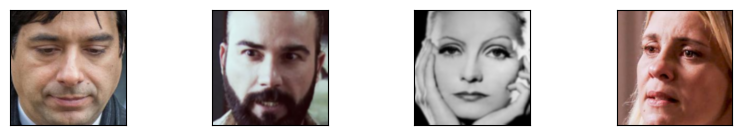

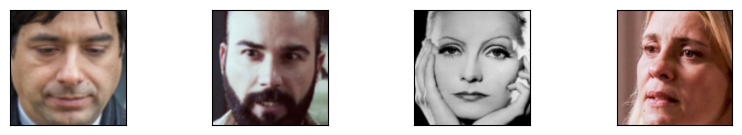

In [54]:
GaussianBlur = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.001, 2)),
])
show_transformation(GaussianBlur)

## 3.6. Random Erasing
Random erasing is a transformation that randomly selects a rectangle region in an image and erases its pixels with random values. It is useful to make the model more robust to occlusions and to get invariance to this kind of noise. I will use the following parameters:

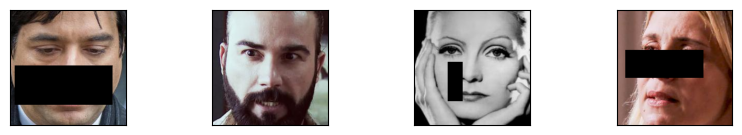

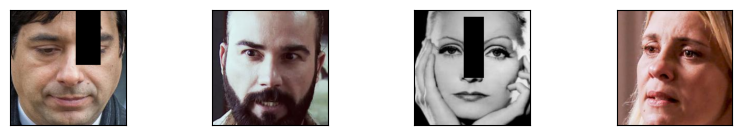

In [55]:
RandomErasing = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.RandomErasing(p = 0.5, scale = (0.02, 0.33), ratio = (0.3, 3.3), value = 0.0, inplace = True),
])
show_transformation(RandomErasing)

## 3.7. Conclusions of data augmentation

Now I can sum up all the transformations and see how they work together:

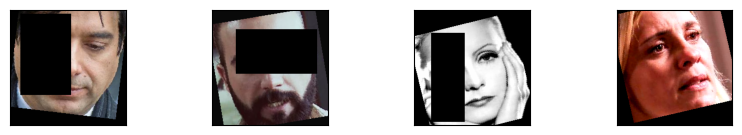

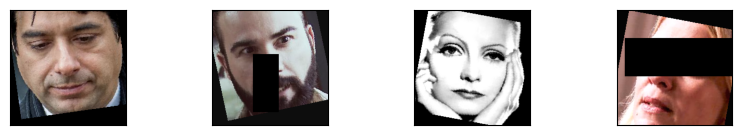

In [56]:
all_transformations = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), 
        scale=(0.9, 1)),
    transforms.ColorJitter(brightness=[0.75, 1.25],contrast = [0.75, 1.25], 
        saturation = [0.75,1.25], hue=[-0.01, 0.01]),
    transforms.RandomErasing(p = 0.5, scale = (0.02, 0.33), ratio = (0.3, 3.3), 
        value = 0.0, inplace = True),
    #transforms.Normalize(mean=mean, std=std, inplace=True)
    ])
show_transformation(all_transformations)

Now with normalization: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


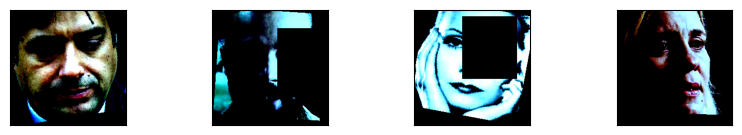

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


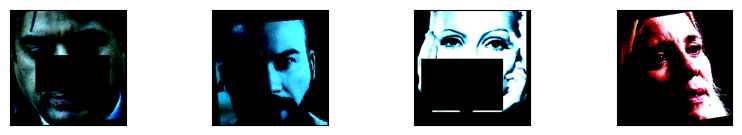

In [57]:
all_transformations = transforms.Compose([
    transforms.ToDtype(torch.float32, scale = True),                                # Convert the image to float32 and scale it to [0,1]
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), 
        scale=(0.9, 1)),
    transforms.ColorJitter(brightness=[0.75, 1.25],contrast = [0.75, 1.25], 
        saturation = [0.75,1.25], hue=[-0.01, 0.01]),
    transforms.RandomErasing(p = 0.5, scale = (0.02, 0.33), ratio = (0.3, 3.3), 
        value = 0.0, inplace = True),
    transforms.Normalize(mean=mean, std=std, inplace=True)
    ])
show_transformation(all_transformations)

In [58]:
# Create the datasets
dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"), img_transforms=all_transformations)
# Create the dataloaders
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False) # No need to shuffle as we are showing the same images
# Compute results
compute_mean_std(dataloader_test)

100%|██████████| 125/125 [00:39<00:00,  3.17it/s]


{'mean': tensor([-0.5069, -0.4291, -0.3815]),
 'std': tensor([1.2145, 1.1620, 1.1148])}

# 4. Conclusions
